## Load Libraries

In [1]:
import xarray as xr 
import glob 
import matplotlib.pyplot as plt
from scipy.signal import detrend

# from windspharm.xarray import VectorWind
import torch_harmonics as harmonics
import torch
import numpy as np
import copy

import credit.pol_lapdiff_filt as plf

import xarray as xr 
import os 
import numpy as np 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle
# from eofs.xarray import Eof

import os
import cartopy.crs as ccrs

import numpy as np
import os
from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment

from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

## Functions

In [97]:
def compute_regression_slopes(DS, DSvar, vardo='TREFHT', re_vars = ['stream_function','vorticity'], region_lat=(-5, 5), region_lon=(190, 240)):
    """
    Compute the regression slopes of each variable re_vars with respect to the spatial mean of vardo
    over a specified region.

    Parameters:
    DS (xarray.Dataset): The dataset containing the variables.
    region_lat (tuple): Latitude bounds for selecting the region (default: (-5, 5)).
    region_lon (tuple): Longitude bounds for selecting the region (default: (190, 240)).

    Returns:
    dict: A dictionary containing the slope datasets for each variable (PS, PRECT, TREFHT).
    """
    
    # Step 1: Select the mean of TREFHT over the specified region
    trefht_mean = DSvar[vardo].sel(latitude=slice(*region_lat), longitude=slice(*region_lon)).mean(dim=['latitude', 'longitude'])
    
    # Step 2: Demean the independent variable (TREFHT)
    trefht_mean_demeaned = trefht_mean - trefht_mean.mean(dim='time')
    
    # Step 3: Loop over each variable and compute the slope at each (lat, lon) point
    regression_slopes = {}
    for var_name in re_vars:
        # Demean the dependent variable at each (lat, lon) point
        y = DS[var_name]
        y_demeaned = y - y.mean(dim='time')
        
        # Compute the slope (cov(y, x) / var(x)) at each (lat, lon) point
        slope = (y_demeaned * trefht_mean_demeaned).mean(dim='time') / (trefht_mean_demeaned ** 2).mean(dim='time')
        
        # Store the slope result for this variable
        regression_slopes[var_name] = slope
    
    return regression_slopes


def plot_ENSO_NA(DS1,DS2):
    levels = list(np.arange(-1.7, 1.75, .05))
    cmap = plt.get_cmap('RdBu_r')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    
    # Define fewer ticks for the colorbar
    fewer_ticks = [-7e-1, -5e-1, -3e-1, -1e-1, 1e-1, 3e-1, 5e-1, 7e-1]  # Select fewer representative levels
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    # Set extent to zoom in on a particular region
    ax.set_extent([2, 359, -80, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]
    
    # Color-filled plot for TREFHT with discrete levels
    prect_plot = DS2['TREFHT'].plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap=cmap, 
        norm=norm, 
        add_colorbar=True, 
        cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
    )
    plt.title('TREFHT (color) and StreamFunction (contours)')
    
    # Adding contour lines for PS
    contour = ax.contour(DS1['stream_function']['longitude'], DS1['stream_function']['latitude'], DS1['stream_function']*1e-6, levels=10, colors='black', transform=ccrs.PlateCarree())
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Adding coastlines and formatting
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))
    
    plt.tight_layout()
    plt.show()

def plot_ENSO_NA_PRECT(DS1, DS2):
    levels = list(np.arange(-1., 1.05, .05)*1e-1)
    cmap = plt.get_cmap('RdBu_r')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    
    # Define fewer ticks for the colorbar
    fewer_ticks = [-7e-2, -5e-2, -3e-2, -1e-2, 1e-2, 3e-2, 5e-2, 7e-2]  # Select fewer representative levels
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    # Set extent to zoom in on a particular region
    ax.set_extent([2, 359, -80, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]
    
    # Color-filled plot for TREFHT with discrete levels
    prect_plot = (DS2['PRECT']*500).plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap=cmap, 
        norm=norm, 
        add_colorbar=True, 
        cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
    )
    plt.title('PRECT (color) and StreamFunction (contours)')
    
    # Adding contour lines for PS
    contour = ax.contour(DS1['stream_function']['longitude'], DS1['stream_function']['latitude'], DS1['stream_function']*1e-6, levels=10, colors='black', transform=ccrs.PlateCarree())
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Adding coastlines and formatting
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))
    
    plt.tight_layout()
    plt.show()

## Open Zarr / CESM

In [58]:
conc = []
for yryr in range(1979,2015):
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32.zarr')
    conc.append(DSdo_1)

DSzarr1 = xr.concat(conc, dim='time')
DScesm_merged = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191/1981-01-02T00Z/1D/SF_VP_CESM_524mb_and_associates.nc')

## Open ML Emulator Model Files

In [100]:
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191/1981-01-02T00Z/1D/averaged_UVTQtotPSPRECTTREFHT*'))
DSs = xr.open_mfdataset(FNS)
DSmerged = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191/1981-01-02T00Z/1D/SF_VP_524mb_and_associates.nc')

## Roll Times to create a 30 day moving mean

In [112]:
%%time
# Step 1: Select the 'TREFHT' and 'PRECT' variables from the original dataset (DSs).
DStref = DSs[['TREFHT', 'PRECT', 'PS']]

# Step 2: Apply a 30-day rolling mean to smooth 'TREFHT' and 'PRECT'.
# 'center=True' centers the rolling window on each point, and 'min_periods=1' ensures that the mean
# is calculated even if fewer than 30 days are available, preventing NaNs near the edges.
DStref_rolling = DStref.rolling(time=30, center=True, min_periods=1).mean().load()
print('done 1')  # Print confirmation when the rolling mean is complete for DStref.

# Step 3: Apply a 30-day rolling mean to the merged dataset (DSmerged) to smooth the data.
Merged_rolling = DSmerged.rolling(time=30, center=True, min_periods=1).mean().load()
print('done 2')  # Print confirmation when the rolling mean is complete for DSmerged.

# Step 4: Subset the smoothed 'TREFHT' and 'PRECT' data to retain only December, January, February, and March (DJFM).
# This is done by filtering based on the 'time' dimension using the 'dt.month' accessor.
DJFM_tref = DStref_rolling.sel(time=Merged_rolling['time'].dt.month.isin([12, 1, 2, 3]))

# Step 5: Similarly, subset the smoothed merged dataset to retain DJFM months.
DJFM_mroll = Merged_rolling.sel(time=Merged_rolling['time'].dt.month.isin([12, 1, 2, 3]))

done 1
done 2
CPU times: user 4min 41s, sys: 1min 51s, total: 6min 32s
Wall time: 5min 45s


## Regress Variables on T2m in the Niño 3.4 Region

In [103]:
regression_slopes_SF = compute_regression_slopes(DJFM_mroll, DJFM_tref, vardo='TREFHT', re_vars = ['stream_function','vorticity'], region_lat=(-5, 5), region_lon=(190, 240))
regression_slopes_TREF = compute_regression_slopes(DJFM_tref, DJFM_tref, vardo='TREFHT', re_vars = ['TREFHT','PRECT'], region_lat=(-5, 5), region_lon=(190, 240))

### ====== ####
DStrefreg = regression_slopes_TREF['TREFHT'].to_dataset(name='TREFHT')
DSprectreg = regression_slopes_TREF['PRECT'].to_dataset(name='PRECT')
DSsf_reg = regression_slopes_SF['stream_function'].to_dataset(name='stream_function')

## Plotting

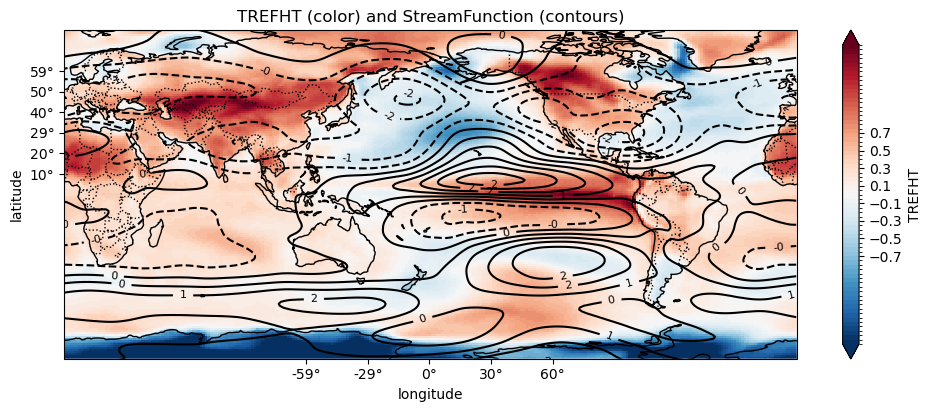

In [104]:
plot_ENSO_NA(DSsf_reg, DStrefreg)

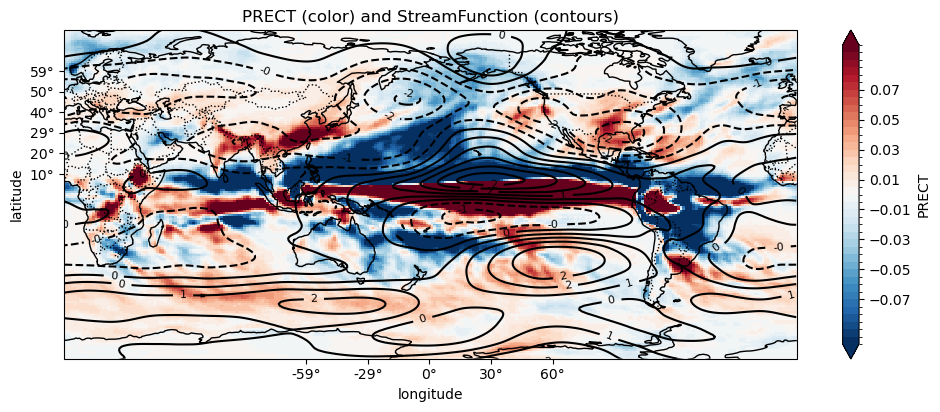

In [106]:
plot_ENSO_NA_PRECT(DSsf_reg, DSprectreg)

## Now for CESM

In [113]:
%%time
# Step 1: Resample the dataset to daily means for specific variables (TREFHT and PRECT),
# then load the resampled data into memory for faster processing.
DSzarr1_TP = DSzarr1[['TREFHT', 'PRECT','PS']].resample(time='1D').mean().load()
print('... resampled and loaded ....')

# Step 2: Apply a 30-day rolling mean to smooth the resampled data.
# 'center=True' centers the rolling window on each point, and 'min_periods=1' ensures
# that the mean is computed even if the full 30 days aren't available (useful near edges).
DSzarrtref_rolling = DSzarr1_TP.rolling(time=30, center=True, min_periods=1).mean().load()

# Step 3: Subset the dataset to retain only data from December, January, February, and March (DJFM),
# filtering the 'time' dimension using the 'dt.month' accessor.
DJFM_zarrtref = DSzarrtref_rolling.sel(time=DSzarr1_TP['time'].dt.month.isin([12, 1, 2, 3]))

# Step 4: Perform linear regression to compute slopes of TREFHT anomalies over the DJFM period.
# The function 'compute_regression_slopes' likely calculates regression slopes for the selected variable
# (TREFHT) within a specified latitude and longitude region.
regression_slopes_TREFcesm = compute_regression_slopes(
    DJFM_zarrtref,  # Predictor dataset (TREFHT, DJFM period)
    DJFM_zarrtref,  # Response dataset (same TREFHT for auto-regression)
    vardo='TREFHT',  # Variable to compute regression for
    re_vars=['TREFHT','PRECT','PS'],  # List of regression variables
    region_lat=(-5, 5),  # Latitude bounds for regression
    region_lon=(190, 240)  # Longitude bounds for regression
)

# Step 5: Convert the regression slopes (for TREFHT) into an xarray Dataset,
# naming the new variable 'TREFHT'.
DStrefreg_zarr = regression_slopes_TREFcesm['TREFHT'].to_dataset(name='TREFHT')

print('...doing stream function...')

# Step 6: Apply a 30-day rolling mean to the CESM merged dataset for further analysis.
Merged_rolling_cesm = DScesm_merged.rolling(time=30, center=True, min_periods=1).mean().load()

# Step 7: Compute regression slopes for stream function and vorticity variables,
# using the smoothed CESM dataset and the DJFM TREFHT dataset as predictors.
regression_slopes_SF_cesm = compute_regression_slopes(
    Merged_rolling_cesm,  # Predictor dataset (stream function and vorticity)
    DJFM_zarrtref,  # Response dataset (DJFM TREFHT)
    vardo='TREFHT',  # Target variable for regression
    re_vars=['stream_function', 'vorticity'],  # Variables for regression
    region_lat=(-5, 5),  # Latitude bounds
    region_lon=(190, 240)  # Longitude bounds
)

DStrefreg_cesm = regression_slopes_TREFcesm['TREFHT'].to_dataset(name='TREFHT')
DSprectreg_cesm = regression_slopes_TREFcesm['PRECT'].to_dataset(name='PRECT')
DSsf_reg_cesm = regression_slopes_SF_cesm['stream_function'].to_dataset(name='stream_function')

... resampled and loaded ....
...doing stream function...
CPU times: user 9min 34s, sys: 3min 14s, total: 12min 48s
Wall time: 14min 46s


In [72]:
DStrefreg_cesm = regression_slopes_TREFcesm['TREFHT'].to_dataset(name='TREFHT')
DSprectreg_cesm = regression_slopes_TREFcesm['PRECT'].to_dataset(name='PRECT')
DSsf_reg_cesm = regression_slopes_SF_cesm['stream_function'].to_dataset(name='stream_function')

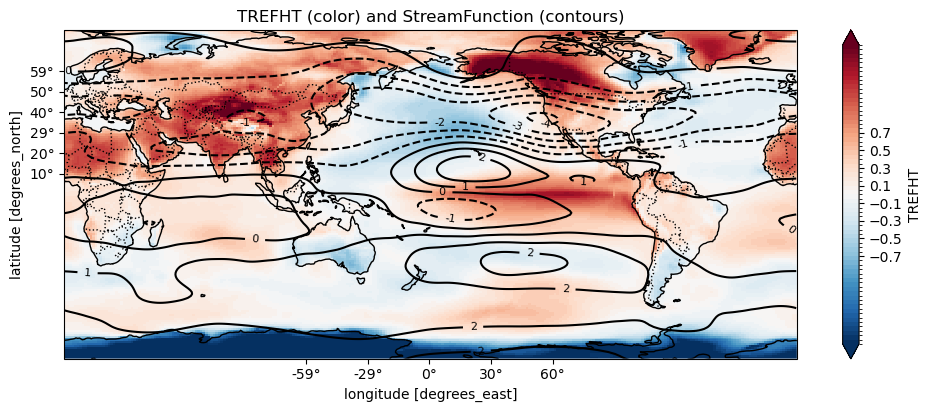

In [76]:
plot_ENSO_NA(DSsf_reg_cesm, DStrefreg_cesm)

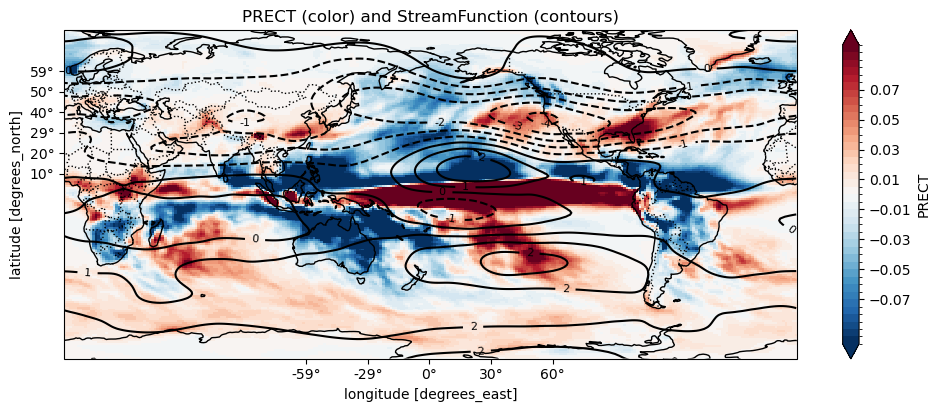

In [98]:
plot_ENSO_NA_PRECT(DSsf_reg_cesm, DSprectreg_cesm)

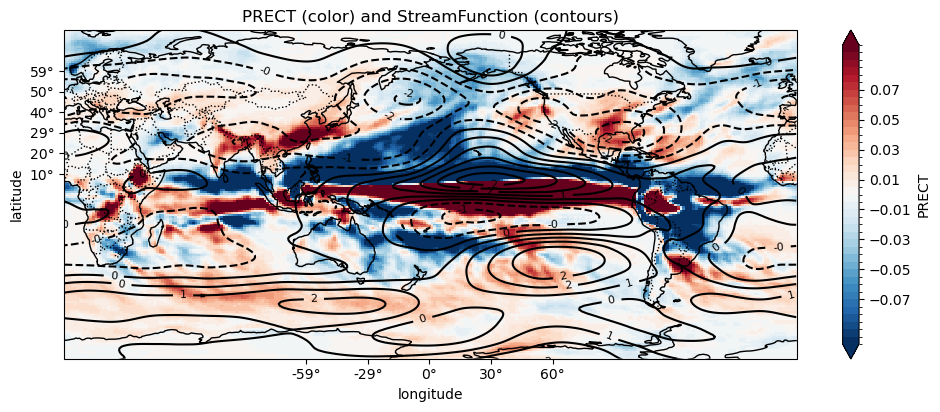

In [107]:
plot_ENSO_NA_PRECT(DSsf_reg, DSprectreg)

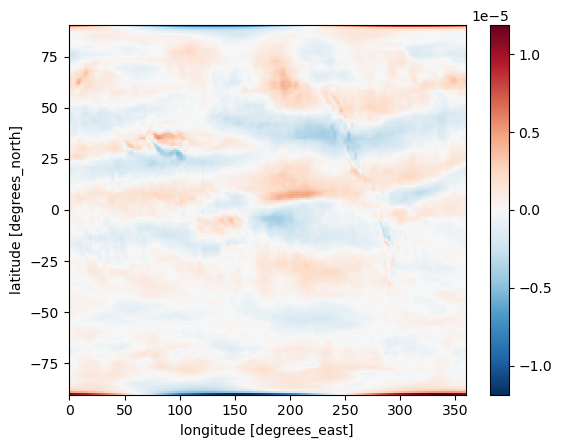

In [110]:
regression_slopes_SF_cesm['vorticity'].plot()

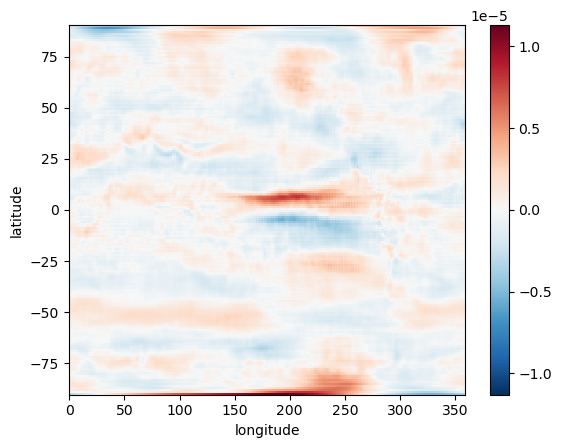

In [111]:
regression_slopes_SF['vorticity'].plot()